In [1]:
!nvidia-smi

Mon Jul 20 17:09:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:B2:00.0 Off |                  N/A |
|  0%   34C    P8     6W / 250W |     15MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import imageio
import sklearn
import warnings
import numpy as np
import astropy.stats as st
import collections as col
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import collections as col
import torchvision.models as models
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
from ulmo.models import AutoEncoder, ConditionalFlow
from ulmo.models.utils import get_n_params, get_gradient_norm

In [3]:
sns.set_style('white')
plt.rc("axes.spines", top=False, right=False)
plt.rcParams['figure.figsize'] = (8, 5)

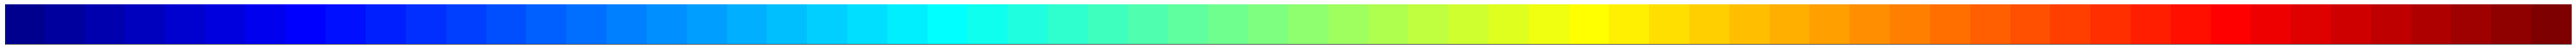

In [4]:
with open('./color_palette.txt', 'r') as f:
    colors = np.array([l.split() for l in f.readlines()]).astype(np.float32)
    pal = sns.color_palette(colors)
    sns.palplot(pal)
    boundaries = np.linspace(0, 1, 64)
    colors = list(zip(boundaries, colors))
    cm = LinearSegmentedColormap.from_list(name='rainbow', colors=colors)

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')

In [6]:
class SSTPatchDataset(torch.utils.data.Dataset):
    def __init__(self, filepath, partition, standardize=True, mu=None, stdv=None):
        self.standardize = standardize

        print("Creating dataset from file:", filepath)
        fields = np.load(filepath)[f'{partition.lower()}_fields'].astype(np.float32)
        metadata = np.load(filepath, allow_pickle=True)[f'{partition.lower()}_meta']
        
        if standardize:
            if not mu:
                mu = fields.mean()
            if not stdv:
                stdv = fields.std()
            fields = (fields - mu) / stdv
        
        self.mu = mu
        self.stdv = stdv
        self.fields = torch.from_numpy(fields)
        self.metadata = metadata
        print(f"Data shape: {fields.shape}")
    
    def inverse_transform(self, x):
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
        if self.standardize:
            x = x * self.stdv + self.mu
        return x
        
    def __getitem__(self, i):
        field = self.fields[i][None, :, :]
        meta = self.metadata[i].tolist()
        return field, meta
    
    def __len__(self):
        return self.fields.size(0)

In [7]:
train_dset = SSTPatchDataset('../data/processed/MODIS_night_data_no_mask.npz', 'train')
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=64, drop_last=True, shuffle=True)
valid_dset = SSTPatchDataset('../data/processed/MODIS_night_data_no_mask.npz', 'valid', mu=train_dset.mu, stdv=train_dset.stdv)
valid_loader = torch.utils.data.DataLoader(valid_dset, batch_size=64, drop_last=True, shuffle=False)

Creating dataset from file: ../data/processed/MODIS_night_data_no_mask.npz
Data shape: (53384, 96, 96)
Creating dataset from file: ../data/processed/MODIS_night_data_no_mask.npz
Data shape: (5000, 96, 96)


In [8]:
assert (train_dset.mu == valid_dset.mu) & (train_dset.stdv == valid_dset.stdv)

In [9]:
autoencoder = AutoEncoder.from_file('autoencoder.pt').to(device)

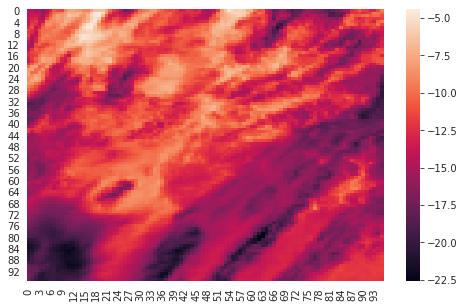

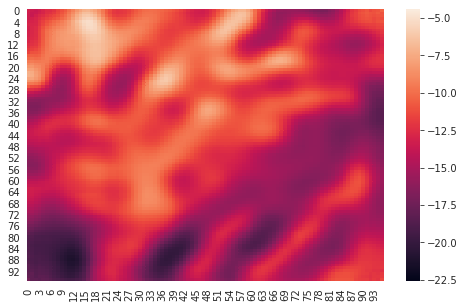

In [14]:
x, meta = next(iter(valid_loader))
rx, z = autoencoder._forward(x.to(device))
idx = np.random.choice(x.size(0))
x = valid_dset.inverse_transform(x)
rx = valid_dset.inverse_transform(rx)
vmin, vmax = x[idx, 0].min(), x[idx, 0].max()
sns.heatmap(x[idx, 0], vmin=vmin, vmax=vmax)
plt.show()
sns.heatmap(rx[idx, 0], vmin=vmin, vmax=vmax)

In [11]:
# Fit standard scaler
latents = []
with torch.no_grad():
    train_latents, valid_latents = [], []
    for x, meta in train_loader:
        _, z = autoencoder._forward(x.to(device))
        latents.append(z.detach().cpu().numpy())

latent_scaler = StandardScaler().fit(np.vstack(latents))
scale = torch.from_numpy(latent_scaler.scale_[None, :]).float().to(device)
mean = torch.from_numpy(latent_scaler.mean_[None, :]).float().to(device)

In [12]:
flow = ConditionalFlow(dim=256, context_dim=None, transform_type='autoregressive', n_layers=10, hidden_units=256,
        n_blocks=1, dropout=0.1, use_batch_norm=False, tails='linear', tail_bound=10, n_bins=5,
        min_bin_height=1e-3, min_bin_width=1e-3, min_derivative=1e-3, unconditional_transform=False, encoder=None)
optimizer = torch.optim.AdamW(flow.parameters(), lr=2.5e-4)

In [13]:
global_step = 0
n_epochs = 200
summary_interval = 50
eval_interval = 500
best_val_loss = np.inf
best_recon_loss = np.inf
metrics = col.defaultdict(list)

In [20]:
try:
    total_loss = 0
    for epoch in range(n_epochs):
        for field, meta in train_loader:
            optimizer.zero_grad()
            with torch.no_grad():
                _, z = autoencoder._forward(field.to(device))
                z = (z - mean) / scale
            loss = flow(z.to(device))
            total_loss += loss.item()
            loss.backward()
            nn.utils.clip_grad_norm_(flow.parameters(), 5)
            optimizer.step()
            global_step += 1
        
            if global_step % summary_interval == 0:
                current_loss = float(total_loss) / summary_interval
                print(f"Loss: {current_loss:.5f} | "
                     f"Gradient norm: {get_gradient_norm(flow):.3f}")
                total_loss = 0
            
            if global_step % eval_interval == 0:
                flow.eval()
                with torch.no_grad():
                    val_loss = 0
                    for i, (field, meta) in enumerate(valid_loader):
                        with torch.no_grad():
                            _, z = autoencoder._forward(field.to(device))
                            z = (z - mean) / scale
                        val_loss += flow(z.to(device)).item()
                    val_loss = float(val_loss) / (i + 1)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    with open('flow.pt', 'wb') as f:
                        torch.save(flow.state_dict(), f)
                print(f"Validation Loss: {val_loss:.5f}")
                flow.train()

except KeyboardInterrupt:
    pass

Loss: 2060.81686 | Gradient norm: 5.000
Loss: 716.41571 | Gradient norm: 5.000
Loss: 451.45363 | Gradient norm: 5.000
Loss: 346.42142 | Gradient norm: 5.000
Loss: 294.00669 | Gradient norm: 5.000
Loss: 264.93322 | Gradient norm: 5.000
Loss: 256.18060 | Gradient norm: 5.000
Loss: 247.00735 | Gradient norm: 5.000
Loss: 232.63773 | Gradient norm: 5.000
Loss: 232.89110 | Gradient norm: 5.000
Validation Loss: 232.32975
Loss: 223.50700 | Gradient norm: 5.000
Loss: 225.70638 | Gradient norm: 5.000
Loss: 216.11352 | Gradient norm: 5.000
Loss: 212.42395 | Gradient norm: 5.000
Loss: 213.39191 | Gradient norm: 5.000
Loss: 209.80169 | Gradient norm: 5.000
Loss: 206.12898 | Gradient norm: 5.000
Loss: 208.55134 | Gradient norm: 5.000
Loss: 249.85667 | Gradient norm: 5.000
Loss: 295.03983 | Gradient norm: 5.000
Validation Loss: 201.57479
Loss: 200.66607 | Gradient norm: 5.000
Loss: 196.55522 | Gradient norm: 5.000
Loss: 200.13914 | Gradient norm: 5.000
Loss: 199.29763 | Gradient norm: 5.000
Loss: 212

In [14]:
flow.load_state_dict(torch.load('./flow.pt'))
flow.eval()
None

In [15]:
flow.eval()
logL, fields, metadata = [], [], []
with torch.no_grad():
    for i, (field, meta) in enumerate(valid_loader):
        _, z = autoencoder._forward(field.to(device))
        z = (z - mean) / scale
        logL.append(flow.log_prob(z.to(device)).detach().cpu().numpy())
        fields.append(field.detach().cpu().numpy()); metadata.append(meta)
logL = np.vstack(logL).flatten()
fields = np.array(fields).reshape([-1, 96, 96])

meta = []
for batch in np.array(metadata):
    files = batch[0]
    rows = list(zip(batch[1][0].cpu().numpy(), batch[1][1].cpu().numpy()))
    cols = list(zip(batch[2][0].cpu().numpy(), batch[2][1].cpu().numpy()))
    meta.append(list(zip(files, rows, cols)))
meta = np.vstack(meta)

-398.2876342773437 108.05672607421903


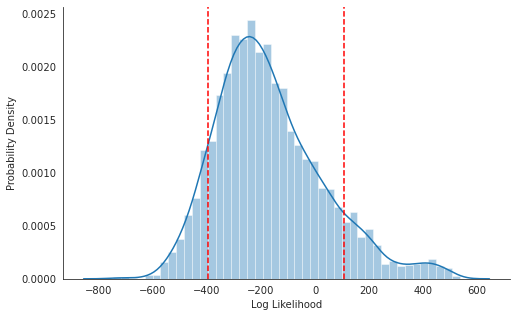

In [16]:
low_logL = np.quantile(logL, 0.10)
high_logL = np.quantile(logL, 0.90)
sns.distplot(logL)
plt.axvline(low_logL, linestyle='--', c='r')
plt.axvline(high_logL, linestyle='--', c='r')
plt.xlabel('Log Likelihood')
plt.ylabel('Probability Density')
print(low_logL, high_logL)

In [17]:
logL.shape, fields.shape, meta.shape

((4992,), (4992, 96, 96), (4992, 3))

In [18]:
outlier_idx = logL < low_logL
outlier_logL = logL[outlier_idx]
outlier_fields = fields[outlier_idx]
outlier_meta = meta[outlier_idx]

In [19]:
outlier_fields = outlier_fields * valid_dset.stdv + valid_dset.mu
# outlier_fields = np.clip(outlier_fields, 0, 32)

In [20]:
outlier_meta

array([['A2005365120500.L2_LAC_SST.nc', (1728, 1824), (869, 965)],
       ['A2005105041500.L2_LAC_SST.nc', (672, 768), (677, 773)],
       ['A2005365121000.L2_LAC_SST.nc', (96, 192), (293, 389)],
       ...,
       ['A2005322185500.L2_LAC_SST.nc', (1824, 1920), (485, 581)],
       ['A2005105140500.L2_LAC_SST.nc', (1248, 1344), (869, 965)],
       ['A2005105190500.L2_LAC_SST.nc', (576, 672), (389, 485)]],
      dtype=object)

In [21]:
idx = np.random.choice(outlier_logL.shape[0], size=16, replace=False)

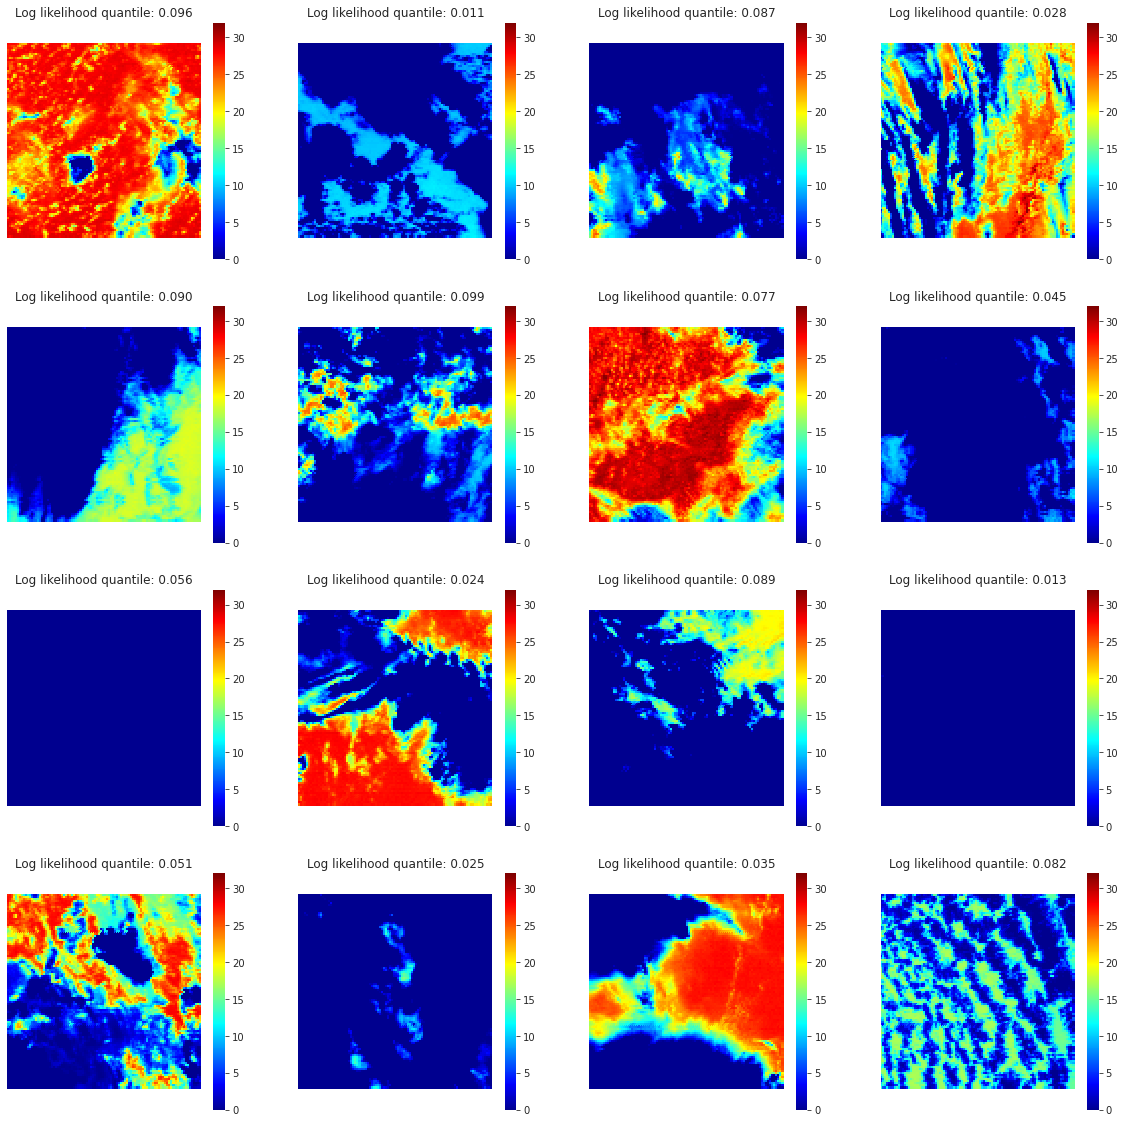

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.ravel()

for i, index in enumerate(idx):
    ax = axes[i]
    ax.axis('equal')
    p = sum(outlier_logL[index] > logL)
    n = len(logL)
    ax.set_title(f'Log likelihood quantile: {p/n:.3f}')
    sns.heatmap(outlier_fields[index], ax=ax, xticklabels=[], yticklabels=[], cmap=cm, vmin=0, vmax=32)

# plt.savefig('../plots/outliers_v2.jpg', bbox_inches='tight')

In [23]:
inlier_idx = logL > high_logL
inlier_logL = logL[inlier_idx]
inlier_fields = fields[inlier_idx]
inlier_meta = meta[inlier_idx]

In [24]:
inlier_fields = inlier_fields * valid_dset.stdv + valid_dset.mu
# inlier_fields = np.clip(inlier_fields, 0, 32)

Text(0.5, 1.0, 'Outliers')

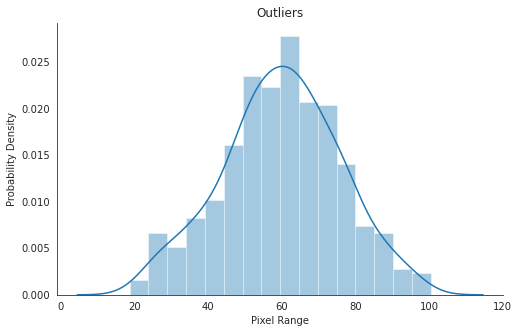

In [25]:
sns.distplot([o.max() - o.min() for o in outlier_fields])
plt.xlabel('Pixel Range')
plt.ylabel('Probability Density')
plt.title('Outliers')

Text(0.5, 1.0, 'Inliers')

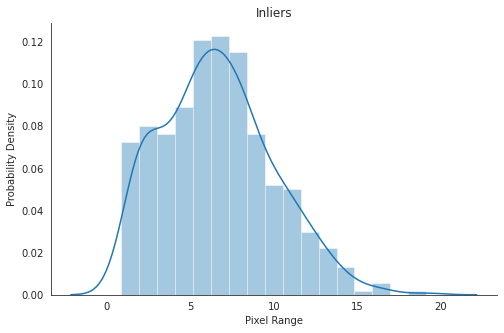

In [26]:
sns.distplot([i.max() - i.min() for i in inlier_fields])
plt.xlabel('Pixel Range')
plt.ylabel('Probability Density')
plt.title('Inliers')

In [27]:
idx = np.random.choice(inlier_logL.shape[0], size=16, replace=False)

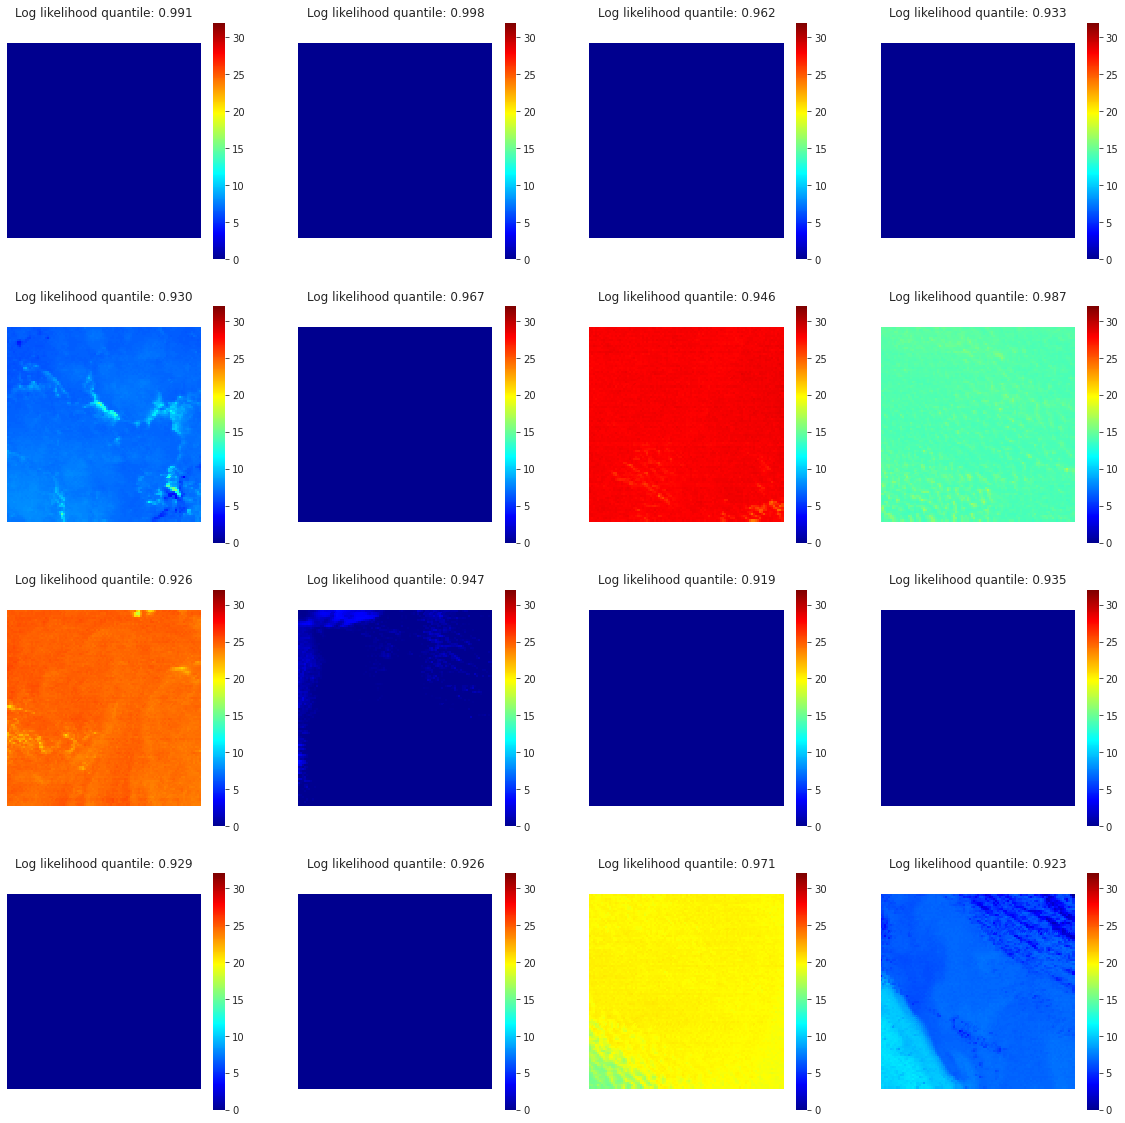

In [28]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.ravel()

for i, index in enumerate(idx):
    ax = axes[i]
    ax.axis('equal')
    p = sum(inlier_logL[index] > logL)
    n = len(logL)
    ax.set_title(f'Log likelihood quantile: {p/n:.3f}')
    sns.heatmap(inlier_fields[index], ax=ax, xticklabels=[], yticklabels=[], cmap=cm, vmin=0, vmax=32)

# plt.savefig('../plots/inliers_v2.jpg', bbox_inches='tight')

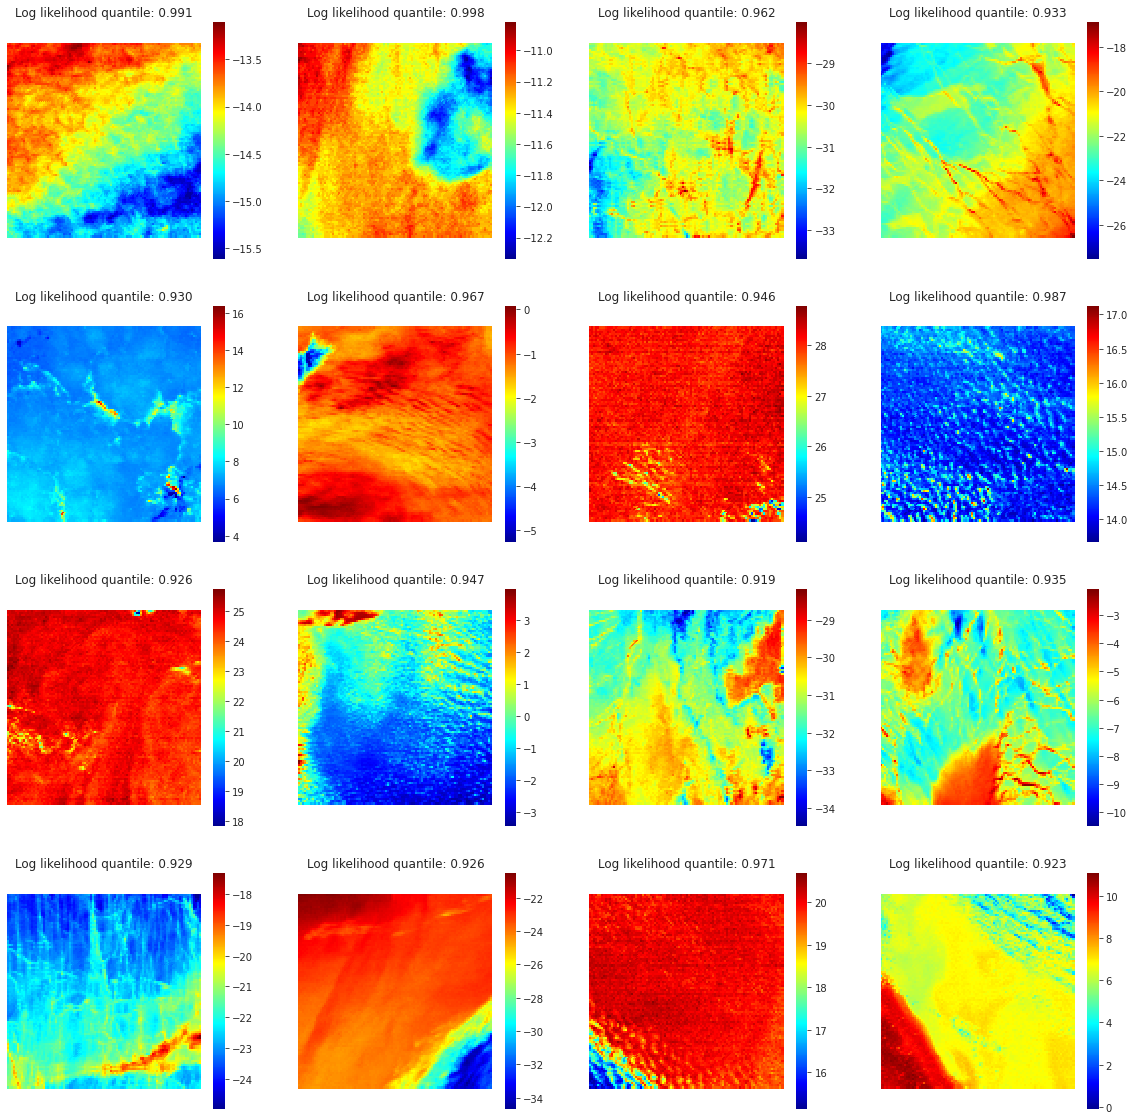

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.ravel()

for i, index in enumerate(idx):
    ax = axes[i]
    ax.axis('equal')
    p = sum(inlier_logL[index] > logL)
    n = len(logL)
    ax.set_title(f'Log likelihood quantile: {p/n:.3f}')
    sns.heatmap(inlier_fields[index], ax=ax, xticklabels=[], yticklabels=[], cmap=cm)

# plt.savefig('../plots/inliers_v2.jpg', bbox_inches='tight')

In [30]:
ranges = [img.max() - img.min() for img in fields]

Text(0, 0.5, 'Log Likelihood')

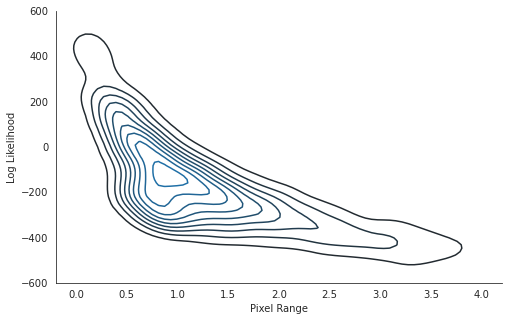

In [31]:
sns.kdeplot(ranges, logL)
plt.xlim(-0.2, 4.2)
plt.ylim(-600, 600)
plt.xlabel('Pixel Range')
plt.ylabel('Log Likelihood')

Text(0, 0.5, 'Probability Density')

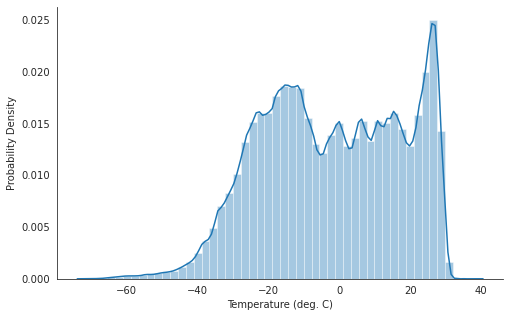

In [32]:
f = fields * valid_dset.stdv + valid_dset.mu
sns.distplot(f.flatten())
plt.xlabel('Temperature (deg. C)')
plt.ylabel('Probability Density')